# Handling Missing Data in Machine Learning: A Comparative Analysis

## Introduction

Handling missing data is a crucial step in any data science project. The way we choose to fill in missing values can greatly affect model performance and overall analysis quality.

In this notebook:

- We simulate missing values in a salary dataset.
- Apply multiple imputation techniques, ranging from simple (mean, median) to advanced (Random Forest, LightGBM, Iterative).
- Evaluate and compare their effectiveness using real error metrics (MAPE and R²).
- Visualize and interpret the results to understand which method performs best for this dataset.

The goal is to highlight how different imputation strategies affect prediction accuracy and provide a visual, data-driven comparison.

## Import Libraries and Load Data

- Import necessary libraries for data handling, visualization, and modeling.
- Read the dataset from `salaries.xlsx`, Sheet1.
- Show the shape and preview the first rows of the dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_main = pd.read_excel("salaries.xlsx", sheet_name="Sheet1")
df_main.shape

(1000, 7)

In [3]:
df_main.head()

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,High School,8,Urban,Manager,63,Male,84620.05
1,PhD,11,Suburban,Director,59,Male,142591.26
2,Bachelor,28,Suburban,Manager,61,Female,97800.26
3,High School,29,Rural,Director,45,Male,96834.67
4,PhD,25,Urban,Analyst,26,Female,132157.79


## Generating Visualizing Random Missing Values

- Encode categorical variables using one-hot encoding.
- Set a random seed for reproducibility.
- Randomly select 50 rows to simulate missing `Salary` values.
- Highlight the 50 planned-to-be-missing salary values in red.

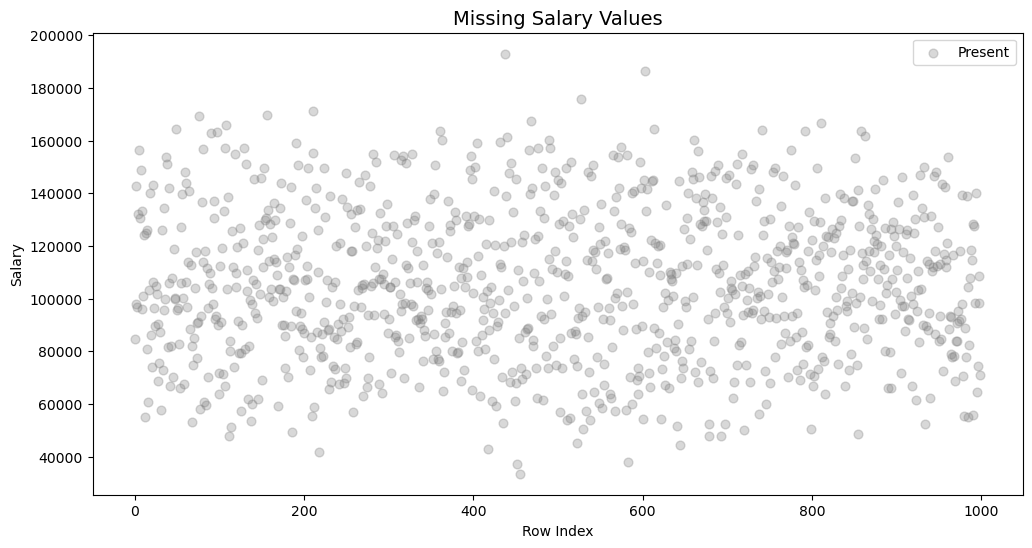

In [4]:
df_encoded = pd.get_dummies(df_main, columns=["Education", "Location", "Job_Title", "Gender"], drop_first=True)

np.random.seed(491)
missing_indices = np.random.choice(df_main.index, size=50, replace=False)

plt.figure(figsize=(12, 6))

plt.scatter(df_encoded.index,
            df_encoded["Salary"],
            color="gray", label="Present", s=40, alpha=0.3)


plt.title("Missing Salary Values", fontsize=14)
plt.xlabel("Row Index")
plt.ylabel("Salary")
plt.legend()
plt.show()

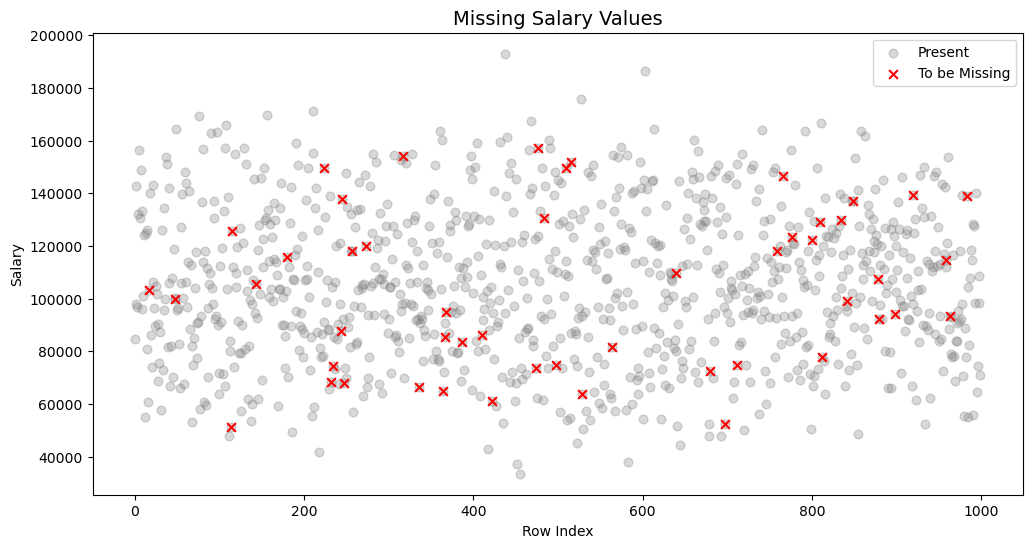

In [5]:
plt.figure(figsize=(12, 6))

plt.scatter(df_encoded.index,
            df_encoded["Salary"],
            color="gray", label="Present", s=40, alpha=0.3)

plt.scatter(missing_indices,
            df_encoded.loc[missing_indices, "Salary"],
            color="red", label="To be Missing", s=40, marker="x")

plt.title("Missing Salary Values", fontsize=14)
plt.xlabel("Row Index")
plt.ylabel("Salary")
plt.legend()
plt.show()

df_missing = df_encoded.copy()
df_missing.loc[missing_indices, "Salary"] = np.nan

## Compare Imputation Methods with Evaluation Metrics

- Store the true `Salary` values before making them missing.
- Apply the following imputation techniques:
  - KNN Imputer
  - Iterative Imputer (BayesianRidge)
  - Multiple Imputation (5 Iterative Imputers with different seeds)
  - Mean, Median, Mode, and Constant Imputers
  - Random Forest Regressor
  - LightGBM Regressor
- Predict the missing values with each method.
- Calculate MAPE and R² scores by comparing predicted values with actual values.
- Display all results in a sorted DataFrame for comparison.

In [6]:
actual_salary = df_encoded.loc[missing_indices, "Salary"]

# KNN Imputer
imputer_knn = KNNImputer(n_neighbors=5)
df_imputed_knn = pd.DataFrame(imputer_knn.fit_transform(df_missing), columns=df_missing.columns)
predicted_salary_knn = df_imputed_knn.loc[missing_indices, "Salary"]

# Iterative Imputer (BayesianRidge)
imputer_iterative = IterativeImputer(random_state=42)
df_imputed_iterative = pd.DataFrame(imputer_iterative.fit_transform(df_missing), columns=df_missing.columns)
predicted_salary_iterative = df_imputed_iterative.loc[missing_indices, "Salary"]

# Multiple Imputation (Multiple Iterative Imputer Runs)
imputations = []
for seed in [42, 43, 44, 45, 46]:  # 5 farklı random_state
    imputer_multi = IterativeImputer(random_state=seed, sample_posterior=True)
    df_imputed_multi = pd.DataFrame(imputer_multi.fit_transform(df_missing), columns=df_missing.columns)
    imputations.append(df_imputed_multi.loc[missing_indices, "Salary"].values)
predicted_salary_multi = np.mean(imputations, axis=0)

# Mean Imputer
df_mean = df_missing.copy()
df_mean["Salary"] = df_mean["Salary"].fillna(df_mean["Salary"].mean())
predicted_salary_mean = df_mean.loc[missing_indices, "Salary"]

# Median Imputer
df_median = df_missing.copy()
df_median["Salary"] = df_median["Salary"].fillna(df_median["Salary"].median())
predicted_salary_median = df_median.loc[missing_indices, "Salary"]

# Mode Imputer
df_mode = df_missing.copy()
df_mode["Salary"] = df_mode["Salary"].fillna(df_mode["Salary"].mode()[0])
predicted_salary_mode = df_mode.loc[missing_indices, "Salary"]

# Constant Value Imputer (Example: 0)
df_constant = df_missing.copy()
df_constant["Salary"] = df_constant["Salary"].fillna(0)
predicted_salary_constant = df_constant.loc[missing_indices, "Salary"]

# Random Forest Imputer (Manual)
df_train = df_missing[df_missing["Salary"].notna()]
X_train = df_train.drop(columns=["Salary"])
y_train = df_train["Salary"]
X_test = df_missing.loc[missing_indices].drop(columns=["Salary"])
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
predicted_salary_rf = rf.predict(X_test)

# LightGBM Imputer (Manual)
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}
model_lgb = lgb.train(params, lgb_train, num_boost_round=100)
predicted_salary_lgb = model_lgb.predict(X_test)

# metrics calculation
def calculate_metrics(actual, predicted):
    mape = ((np.abs(predicted - actual) / actual).mean()) * 100
    r2 = r2_score(actual, predicted)
    return mape, r2

# all metrics
metrics = {
    "KNN_Imputer": calculate_metrics(actual_salary, predicted_salary_knn),
    "Iterative_Imputer": calculate_metrics(actual_salary, predicted_salary_iterative),
    "Multiple_Imputation": calculate_metrics(actual_salary, predicted_salary_multi),
    "Mean_Imputer": calculate_metrics(actual_salary, predicted_salary_mean),
    "Median_Imputer": calculate_metrics(actual_salary, predicted_salary_median),
    "Mode_Imputer": calculate_metrics(actual_salary, predicted_salary_mode),
    "Constant_Imputer": calculate_metrics(actual_salary, predicted_salary_constant),
    "RandomForest_Imputer": calculate_metrics(actual_salary, predicted_salary_rf),
    "LightGBM_Imputer": calculate_metrics(actual_salary, predicted_salary_lgb),
}

# metrics_df
metrics_df = pd.DataFrame(metrics, index=["MAPE (%)", "R2 Score"]).T
metrics_df = metrics_df.sort_values("R2 Score", ascending=False).reset_index()
metrics_df = metrics_df.rename(columns={"index": "Method"})

metrics_df

,Method,MAPE (%),R2 Score
0,Iterative_Imputer,4.600533,0.949479
1,LightGBM_Imputer,5.605447,0.934285
2,RandomForest_Imputer,5.851806,0.919181
3,Multiple_Imputation,6.667724,0.900428
4,KNN_Imputer,18.785439,0.501166
5,Median_Imputer,28.491601,-0.000622
6,Mean_Imputer,28.906402,-0.004809
7,Mode_Imputer,64.578782,-5.542180
8,Constant_Imputer,100.000000,-12.110766


## Visualize Imputation Method Performance

- The first barplot shows the R² score of each imputation method.
- Higher R² scores mean better predictions.
- The second barplot shows the MAPE (%) values.
- Lower MAPE values indicate more accurate imputations.
- Methods are sorted for easier comparison.

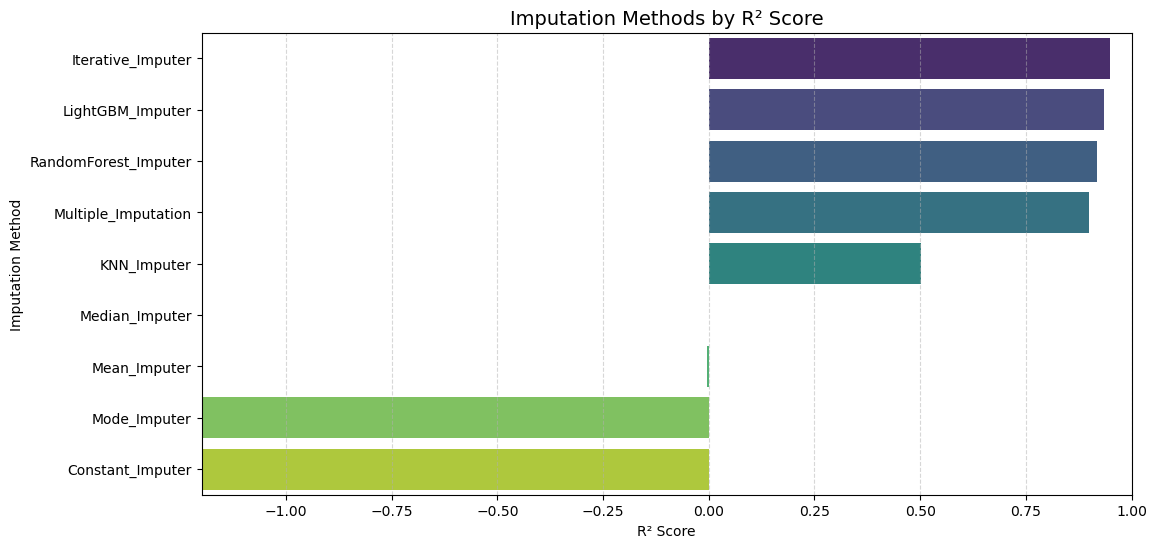

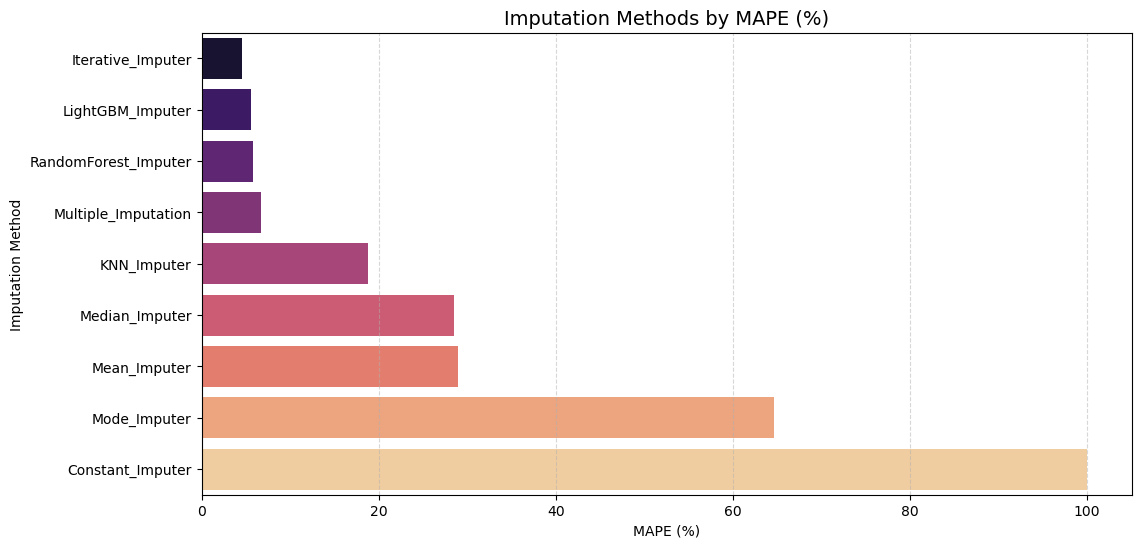

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x="R2 Score", y="Method", palette="viridis")
plt.title("Imputation Methods by R² Score", fontsize=14)
plt.xlabel("R² Score")
plt.ylabel("Imputation Method")
plt.xlim(-1.2, 1.0)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df.sort_values("MAPE (%)", ascending=True),
            x="MAPE (%)", y="Method", palette="magma")
plt.title("Imputation Methods by MAPE (%)", fontsize=14)
plt.xlabel("MAPE (%)")
plt.ylabel("Imputation Method")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

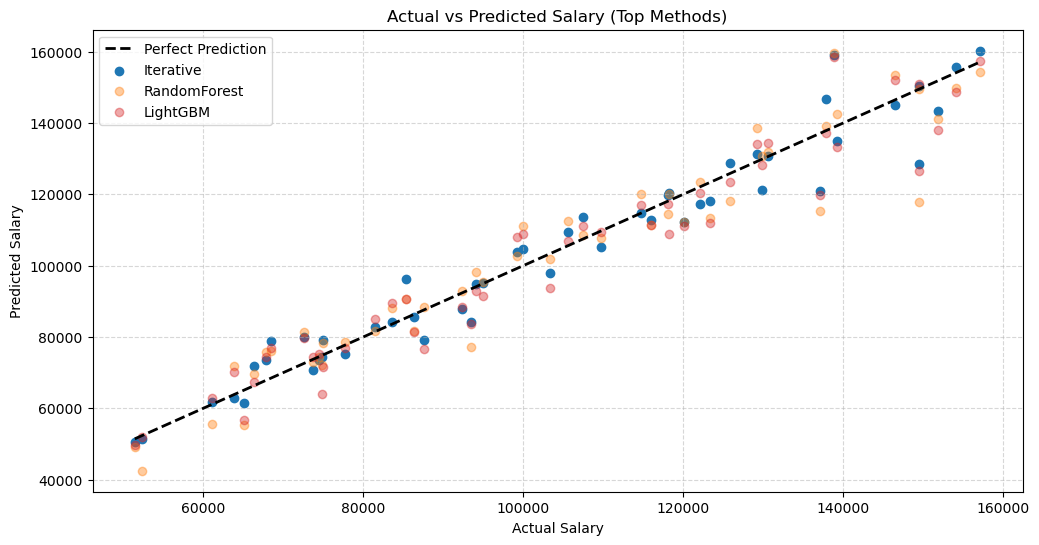

In [8]:
plt.figure(figsize=(12, 6))
plt.plot([actual_salary.min(), actual_salary.max()],
         [actual_salary.min(), actual_salary.max()],
         color="black", linestyle="--", linewidth=2, label="Perfect Prediction")

plt.scatter(actual_salary, predicted_salary_iterative,
            color="#1f77b4", alpha=1, label="Iterative")

plt.scatter(actual_salary, predicted_salary_rf,
            color="#ff7f0e", alpha=0.4, label="RandomForest")

plt.scatter(actual_salary, predicted_salary_lgb,
            color="#d62728", alpha=0.4, label="LightGBM")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary (Top Methods)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Conclusion

- **Iterative Imputer** achieved the best performance with the highest R² score (0.95) and the lowest MAPE (4.6%).  
- **LightGBM** and **Random Forest** also performed well, showing strong predictive power for missing salaries.  
- **Multiple Imputation** gave slightly lower performance but still outperformed most single-value imputers.  
- Simpler methods like **KNN**, **Mean**, **Median**, **Mode**, and **Constant** had significantly lower accuracy.  
- **Mode** and **Constant Imputer** performed the worst, introducing large errors and even negative R² scores.  

Model-based imputation methods (especially Iterative and boosting algorithms) are clearly more reliable for estimating missing numerical values in this dataset.